# Reuters: Classificação de Tópicos de Notícias

In [1]:
from keras.utils import set_random_seed
import numpy as np
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

set_random_seed(0)
np.random.seed(0)

In [2]:
### Loading the Reuters dataset

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(len(train_data))
print(len(test_data))
print(train_data[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [3]:
### Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(decoded_newswire[4:])

label_index = reuters.get_label_names()
print(label_index)
print(label_index[train_labels[0]])


? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
('cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing', 'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton', 'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp', 'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal', 'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs', 'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver', 'wpi', 'hog', 'lead')
earn


**Preparação dos dados**

In [4]:
### Encoding the data

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Para vetorizar os rótulos, existem duas possibilidades: você pode converter a lista de rótulos em um tensor de números inteiros, ou pode usar a codificação *one-hot*. A codificação *one-hot* é um formato amplamente utilizado para dados categóricos, também chamado de **codificação categórica**. Neste caso, a codificação *one-hot* dos rótulos consiste em incorporar cada rótulo como um vetor todo-zero com um 1 no local do índice do rótulo. Aqui está um exemplo:

In [5]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

#there is a built-in way to do this in Keras
from keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

**Construindo a rede**

Esse problema de classificação de tópicos parece semelhante ao problema anterior de classificação de resenha de filmes: em ambos os casos, você está tentando classificar trechos curtos de texto. Mas há uma nova restrição aqui: o número de classes de saída aumentou de 2 para 46. O número de dimensões do espaço de saída é muito maior.

Em uma pilha de camadas `Dense` como a que estamos usando, cada camada só pode acessar informações presentes na saída da camada anterior. Se uma camada descartar algumas informações relevantes para o problema de classificação, essas informações nunca poderão ser recuperadas por camadas posteriores: cada camada pode se tornar potencialmente um gargalo de informação. No exemplo anterior, usamos camadas intermediárias de 16 dimensões, mas um espaço de 16 dimensões pode ser muito limitado para aprender a separar 46 classes diferentes: essas camadas pequenas podem atuar como gargalos de informação, descartando permanentemente informações relevantes.

Por esse motivo, usaremos camadas maiores, com 64 unidades.

In [6]:
### Defining the model

from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Existem mais duas coisas que se deve observar sobre esta arquitetura:

- A rede encerra com uma camada `Dense` de tamanho 46. Isso significa que, para cada amostra de entrada, a rede produzirá um vetor de 46 dimensões. Cada entrada neste vetor (cada dimensão) codificará uma classe de saída diferente.
- A última camada usa uma ativação `softmax`. Vimos esse padrão no exemplo do MNIST. Isso significa que a rede produzirá uma **distribuição de probabilidade** sobre as 46 diferentes classes de saída - para cada amostra de entrada, a rede produzirá um vetor de saída de 46 dimensões, onde `output[i]` é a probabilidade de que a amostra pertença à classe i. As 46 pontuações somarão 1.

A melhor função de perda a ser usada neste caso é `categorical_crossentropy`. Ela mede a distância entre duas distribuições de probabilidade: neste caso, entre a distribuição de probabilidade produzida pela rede e a verdadeira distribuição dos rótulos. Ao minimizar a distância entre essas duas distribuições, você treina a rede para produzir algo o mais próximo possível dos verdadeiros rótulos.

In [7]:
### Compiling the model

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

**Validando a abordagem**

In [8]:
### Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### Training the model
history = model.fit(partial_x_train, partial_y_train,
epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3219 - loss: 3.2579 - val_accuracy: 0.5920 - val_loss: 1.8752
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6423 - loss: 1.6662 - val_accuracy: 0.6980 - val_loss: 1.3681
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7486 - loss: 1.2009 - val_accuracy: 0.7510 - val_loss: 1.1740
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7931 - loss: 0.9670 - val_accuracy: 0.7770 - val_loss: 1.0647
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8245 - loss: 0.8014 - val_accuracy: 0.7870 - val_loss: 0.9895
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8536 - loss: 0.6686 - val_accuracy: 0.7970 - val_loss: 0.9368
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8790 - loss: 0.5593 - val_accuracy: 0.8040 - val_loss: 0.9013
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8967 - loss: 0.4694 - val_accuracy: 0.8070 - val_loss

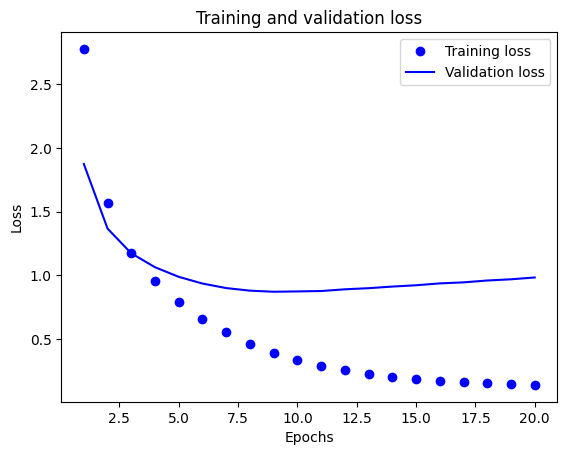

In [9]:
###Plotting the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


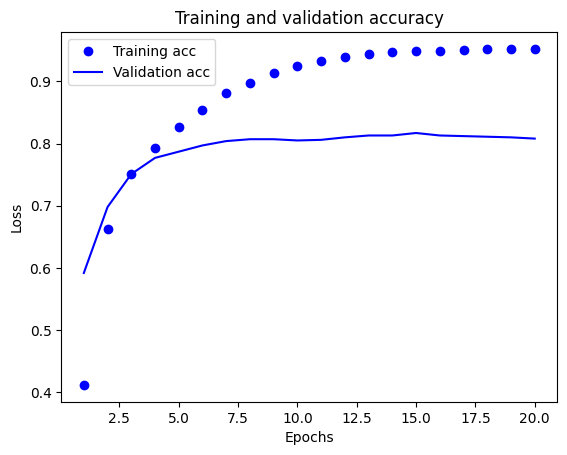

In [10]:
###Plotting the training and validation accuracy
plt.clf()
history_dict = history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

A rede começa a sofrer *overfitting* após nove épocas. Vamos treinar uma nova rede do zero por nove épocas e depois avaliá-la no conjunto de teste.

In [11]:
### Retraining a model from scratch

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=9,
batch_size=512,
validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/9


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3949 - loss: 3.2254 - val_accuracy: 0.6350 - val_loss: 1.8264
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6756 - loss: 1.5964 - val_accuracy: 0.6970 - val_loss: 1.3877
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7330 - loss: 1.1944 - val_accuracy: 0.7360 - val_loss: 1.2085
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7870 - loss: 0.9756 - val_accuracy: 0.7690 - val_loss: 1.0926
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8237 - loss: 0.8073 - val_accuracy: 0.7950 - val_loss: 1.0110
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8547 - loss: 0.6691 - val_accuracy: 0.8010 - val_loss: 0.9528
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8822 - loss: 0.5529 - val_accuracy: 0.8120 - val_loss: 0.9113
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9054 - loss: 0.4574 - val_accuracy: 0.8110 - val_loss: 0.8896
Epoch 9/9

Essa abordagem atinge uma precisão de ~80%. Com um problema de classificação binária equilibrado, a precisão alcançada por um classificador totalmente aleatório seria de 50%. Mas, neste caso, está mais próxima de 19%, então os resultados parecem bastante bons, pelo menos quando comparados a uma abordagem aleatória.

In [12]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1861086375779163

**Usando uma rede treinada para gerar previsões a partir de novos dados**

In [13]:
predictions = model.predict(x_test)
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(np.argmax(predictions[0]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(46,)
0.9999999
3


**Uma maneira diferente de lidar com os rótulos e a função de perda**

Mencionamos anteriormente que outra maneira de codificar os rótulos seria convertê-los em um tensor de inteiros, assim:

In [14]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

A única coisa que mudaria nessa abordagem é a escolha da função de perda. A função de perda usada anteriormente é a `categorical_crossentropy`, a qual espera que os rótulos sigam uma codificação categórica. Com rótulos inteiros, você deve usar `sparse_categorical_crossentropy`:

In [15]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

**A importância de se ter camadas intermediárias suficientemente grandes**

Mencionamos anteriormente que, devido às saídas finais serem de 46 dimensões, deve-se evitar camadas intermediárias com muito menos de 46 unidades ocultas. Agora, vamos ver o que acontece quando se introduz um gargalo de informação ao ter camadas intermediárias significativamente menores, por exemplo, com 4 dimensões.

In [16]:
### A model with an information bottleneck

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0644 - loss: 3.5448 - val_accuracy: 0.2920 - val_loss: 2.8368
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3016 - loss: 2.5915 - val_accuracy: 0.3030 - val_loss: 2.1318
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3951 - loss: 1.8432 - val_accuracy: 0.6330 - val_loss: 1.5842
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6572 - loss: 1.3625 - val_accuracy: 0.6510 - val_loss: 1.4843
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6791 - loss: 1.2257 - val_accuracy: 0.6560 - val_loss: 1.4623
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6978 - loss: 1.1492 - val_accuracy: 0.6570 - val_loss: 1.4573
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7131 - loss: 1.0863 - val_accuracy: 0.6620 - val_loss: 1.4603
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7303 - loss: 1.0305 - val_accuracy: 0.6660 - val_loss:

A rede atinge agora cerca de 71% de precisão na validação, uma queda absoluta de 8%. Essa queda se deve principalmente ao fato de que você está tentando comprimir muitas informações (informações suficientes para recuperar os hiperplanos de separação de 46 classes) em um espaço intermediário que tem dimensões muito reduzidas. A rede consegue condensar a maioria das informações necessárias nessas representações de 4 dimensões, mas não todas.

## Exercícios

### 1. Use camadas maiores ou menores: 32 unidades, 128 unidades, e assim por diante.

In [17]:
def create_model(architecture, early_stopping_patience=3):
    """Creates a model from a given architecture and fits it to the training data"""
    set_random_seed(0)
    np.random.seed(0)
    model = models.Sequential()
        
    for i, layer in enumerate(architecture['layers']):
        if i == 0:
            model.add(layers.Dense(**layer))
        else:
            model.add(layers.Dense(**layer))

    model.compile(optimizer=architecture['optimizer'],
                    loss=architecture['loss'],
                    metrics=architecture['metrics'])
    
    return model

In [18]:
def fit_model(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=512, early_stopping_patience=3):
    set_random_seed(0)
    np.random.seed(0)
    early_stopping = [EarlyStopping(monitor='val_loss', patience=early_stopping_patience)]
    
    return model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), callbacks=early_stopping)

Primeiramente, vamos testar uma arquitetura com 32 unidades

In [19]:
# Testando arquitetura com 32 unidades
architecture_32u = {
    'layers': [
        {'units': 32, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 32, 'activation': 'relu'},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [20]:
model_32u = create_model(architecture_32u)

In [21]:
# Fit model with one layer
history_32u = fit_model(model_32u, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3036 - loss: 3.4575 - val_accuracy: 0.5740 - val_loss: 2.4206
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5974 - loss: 2.1619 - val_accuracy: 0.6430 - val_loss: 1.7257
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6845 - loss: 1.5514 - val_accuracy: 0.6910 - val_loss: 1.4316
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7370 - loss: 1.2554 - val_accuracy: 0.7220 - val_loss: 1.2737
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7735 - loss: 1.0727 - val_accuracy: 0.7490 - val_loss: 1.1745
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8021 - loss: 0.9389 - val_accuracy: 0.7620 - val_loss: 1.1026
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8237 - loss: 0.8290 - val_accuracy: 0.7710 - val_loss: 1.0463
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8419 - loss: 0.7350 - val_accuracy: 0.7870 - 

In [22]:
# Evaluate model: test loss and accuracy
model_32u.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7894 - loss: 1.0210


[1.0492380857467651, 0.7782725095748901]

Testando arquitetura com 128 unidades

In [23]:
# Testando arquitetura com 128 unidades
architecture_128u = {
    'layers': [
        {'units': 128, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 128, 'activation': 'relu'},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [24]:
model_128u = create_model(architecture_128u)

In [25]:
# Fit model with one layer
history_128u = fit_model(model_128u, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4202 - loss: 2.8577 - val_accuracy: 0.6660 - val_loss: 1.4976
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7052 - loss: 1.3336 - val_accuracy: 0.7530 - val_loss: 1.1852
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7833 - loss: 0.9896 - val_accuracy: 0.7930 - val_loss: 1.0306
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8307 - loss: 0.7667 - val_accuracy: 0.8040 - val_loss: 0.9349
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8680 - loss: 0.6052 - val_accuracy: 0.8160 - val_loss: 0.8809
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8975 - loss: 0.4747 - val_accuracy: 0.8190 - val_loss: 0.8512
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9217 - loss: 0.3669 - val_accuracy: 0.8230 - val_loss: 0.8490
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9305 - loss: 0.3038 - val_accuracy: 0.8200

In [26]:
# Evaluate model: test loss and accuracy
model_128u.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8129 - loss: 0.9431


[0.9782649278640747, 0.799198567867279]

Testando arquitetura com 256 unidades

In [27]:
architecture_256u = {
    'layers': [
        {'units': 256, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 256, 'activation': 'relu'},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [28]:
model_256u = create_model(architecture_256u)

In [29]:
history_256u = fit_model(model_256u, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4220 - loss: 2.6867 - val_accuracy: 0.6940 - val_loss: 1.3669
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7321 - loss: 1.1972 - val_accuracy: 0.7640 - val_loss: 1.0849
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8065 - loss: 0.8580 - val_accuracy: 0.7900 - val_loss: 0.9493
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8525 - loss: 0.6402 - val_accuracy: 0.8160 - val_loss: 0.8691
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8926 - loss: 0.4844 - val_accuracy: 0.8090 - val_loss: 0.8419
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9141 - loss: 0.3710 - val_accuracy: 0.8190 - val_loss: 0.8374
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9352 - loss: 0.2709 - val_accuracy: 0.8190 - val_loss: 0.8554
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9417 - loss: 0.2295 - val_accuracy: 0.

In [30]:
# Evaluate model: test loss and accuracy
model_256u.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8136 - loss: 0.9383


[0.9694114923477173, 0.8036509156227112]

Testando arquitetura com 512 unidades

In [31]:
architecture_512u = {
    'layers': [
        {'units': 512, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 512, 'activation': 'relu'},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [32]:
model_512u = create_model(architecture_512u)

In [33]:
history_512u = fit_model(model_512u, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4273 - loss: 2.5615 - val_accuracy: 0.7030 - val_loss: 1.2896
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7444 - loss: 1.1284 - val_accuracy: 0.7780 - val_loss: 1.0263
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8171 - loss: 0.7827 - val_accuracy: 0.8110 - val_loss: 0.8832
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8606 - loss: 0.5919 - val_accuracy: 0.8210 - val_loss: 0.8244
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9055 - loss: 0.4057 - val_accuracy: 0.8150 - val_loss: 0.8367
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9299 - loss: 0.2936 - val_accuracy: 0.8300 - val_loss: 0.8125
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9418 - loss: 0.2299 - val_accuracy: 0.8200 - val_loss: 0.8264
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9474 - loss: 0.1878 - val_accuracy: 0.

In [34]:
# Evaluate model: test loss and accuracy
model_512u.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.9546


[0.9942951202392578, 0.8027604818344116]

In [35]:
def plot_bar_stats_chart(models: list, labels: list, x_test, y_test, title: str='Comparação de modelos',
                         precision: int=2, save_path: str=None):
    """Plots a bar chart with the test accuracy, f1 -core, roc_auc_score of the models
    The x values are the metrics and the bar colors are the models"""

    # Change plot style
    plt.style.use('ggplot')

    metrics = ['accuracy', 'f1_score', 'roc_auc_score']
    scores = []
    
    for model in models:
        y_pred = model.predict(x_test)
        y_pred_argmax = np.argmax(y_pred, axis=1)
        scores.append(
            [
                accuracy_score(y_test, y_pred_argmax),
                f1_score(y_test, y_pred_argmax, average='weighted'),
                roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
                ]
                )
        
    scores = np.array(scores)
    
    fig, ax = plt.subplots()
    width = 1 / (len(labels) + 1)
    x = np.arange(len(metrics))
    
    for i, label in enumerate(labels):
        ax.bar(x + i*width, scores[i], width, label=label)


    # Add bar values to the top of the bars
    for i, score in enumerate(scores):
        for j, value in enumerate(score):
            ax.text(j + i*width, value + 0.01, str(round(value, precision)), ha='center', va='bottom')
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics)
    
    # Plot legend on the right outside of the plot
    ax.legend(title='Tipos de modelo', loc='center left', bbox_to_anchor=(1, 0.5))

    if title:
        plt.title(title)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


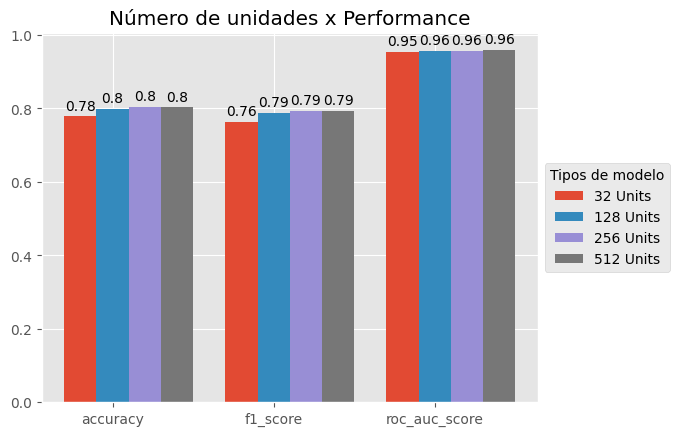

In [36]:
n_units_models = [model_32u, model_128u, model_256u, model_512u]
n_units_labels = ['32 Units', '128 Units', '256 Units', '512 Units']
plot_bar_stats_chart(n_units_models, n_units_labels, x_test, y_test,
                     title='Número de unidades x Performance', save_path='./img/comparacao_n_unidades.png')

In [37]:
def generate_model_stats_table(models: list, labels: list, x_test, y_test, precision: int=2):
    """Generates a table with the test accuracy, f1 -core, roc_auc_score of the models"""

    metrics = ['accuracy', 'f1_score', 'roc_auc_score']
    scores = []
    
    for model in models:
        y_pred = model.predict(x_test)
        y_pred_argmax = np.argmax(y_pred, axis=1)
        scores.append(
            [
                accuracy_score(y_test, y_pred_argmax),
                f1_score(y_test, y_pred_argmax, average='weighted'),
                roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
                ]
                )
        
    scores = np.array(scores)
    
    table = pd.DataFrame(scores, columns=metrics, index=labels)
    table = table.round(precision)
    
    return table

In [38]:
generate_model_stats_table(n_units_models, n_units_labels, x_test, y_test, precision=3)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,accuracy,f1_score,roc_auc_score
32 Units,0.778,0.763,0.955
128 Units,0.799,0.787,0.957
256 Units,0.804,0.793,0.958
512 Units,0.803,0.792,0.959


### Análise

A arquitetura com 256 unidades foi a que obteve o melhor resultado, o que indica que arquiteturas menores não tem complexidade suficiente para aprender todos os padrões presentes nos dados para separar as 46 classes. Contudo, é notável que a diferença entre as arquiteturas de 256 e 512 unidades é muito pequena, o que indica que a arquitetura com 256 unidades já é suficiente para resolver o problema.

| Arquitetura | accuracy | f1_score | roc_auc_score |
|-------------|----------|----------|---------------|
| 32 Units    | 77.8%    | 76.3%    | 95.5%         |
| 128 Units   | 79.9%    | 78.7%    | 95.7%         |
| 256 Units   | 80.4%    | 79.3%    | 95.8%         |
| 512 Units   | 80.1%    | 79.1%    | 95.9%         |

### 2. Usamos duas camadas ocultas `Dense`. Agora, use uma única camada oculta ou três camadas ocultas.

Primeiramente, vamos testar uma arquitetura com uma única camada oculta

In [39]:
arquitecture_1layer = {
    'layers': [
        {'units': 32, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [40]:
model_1layer = create_model(arquitecture_1layer)

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
history_1layer = fit_model(model_1layer, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3693 - loss: 3.4502 - val_accuracy: 0.5370 - val_loss: 2.5250
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6003 - loss: 2.2789 - val_accuracy: 0.6540 - val_loss: 1.8804
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6938 - loss: 1.6795 - val_accuracy: 0.6860 - val_loss: 1.5472
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7357 - loss: 1.3492 - val_accuracy: 0.7220 - val_loss: 1.3450
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7725 - loss: 1.1324 - val_accuracy: 0.7480 - val_loss: 1.2139
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7984 - loss: 0.9783 - val_accuracy: 0.7610 - val_loss: 1.1242
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8147 - loss: 0.8601 - val_accuracy: 0.7750 - val_loss: 1.0584
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8382 - loss: 0.7640 - val_accuracy: 0.7870 - 

Agora, vamos testar uma arquitetura com três camadas ocultas

In [42]:
model_1layer.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.8118 - loss: 0.8848


[0.9313241839408875, 0.7974176406860352]

In [43]:
arquitecture_3layers = {
    'layers': [
        {'units': 32, 'activation': 'relu'},
        {'units': 32, 'activation': 'relu'},
        {'units': 32, 'activation': 'relu'},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}


In [44]:
model_3layers = create_model(arquitecture_3layers)

In [45]:
history_3layers = fit_model(model_3layers, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2693 - loss: 3.5425 - val_accuracy: 0.4850 - val_loss: 2.5408
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5416 - loss: 2.2508 - val_accuracy: 0.6140 - val_loss: 1.7950
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6634 - loss: 1.6066 - val_accuracy: 0.6840 - val_loss: 1.4920
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7238 - loss: 1.3068 - val_accuracy: 0.7080 - val_loss: 1.3348
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7537 - loss: 1.1187 - val_accuracy: 0.7270 - val_loss: 1.2327
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7781 - loss: 0.9769 - val_accuracy: 0.7430 - val_loss: 1.1574
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8018 - loss: 0.8579 - val_accuracy: 0.7650 - val_loss: 1.1018
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8254 - loss: 0.7544 - val_accuracy: 0.7770 - 

In [46]:
model_3layers.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7873 - loss: 1.0192


[1.0626031160354614, 0.7756010890007019]

#### Análise

O modelo com uma única camada oculta teve acurácia de 79,7%, enquanto o modelo de 3 camadas ocultas teve acurácia de 77,6%. Isso provavelmente ocorreu porque o modelo com uma única camada oculta tem complexidade suficiente para aprender os padrões presentes nos dados e separar as 46 classes, enquanto o modelo com 3 camadas ocultas pode ser mais complexo do que o necessário, teve mais overfitting - o que é uma tendência para o aumento do número de camadas.

Uma solução para o overfitting seria adicionar regularização às camadas ocultas. Vamos testar isso.

Arquitetura com regularização L1

In [56]:
reg_weight = 10e-6
architecture_3layers_reg_l1 = {
    'layers': [
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L1(reg_weight), 'activity_regularizer': regularizers.L1(reg_weight),
         'input_shape': (10000,)},
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L1(reg_weight), 'activity_regularizer': regularizers.L1(reg_weight)
         },
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L1(reg_weight), 'activity_regularizer': regularizers.L1(reg_weight)},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
} 

In [57]:
model_3layers_reg_l1 = create_model(architecture_3layers_reg_l1)

In [58]:
history_3layers_reg_l1 = fit_model(model_3layers_reg_l1, partial_x_train, partial_y_train, x_val, y_val, epochs=200)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2811 - loss: 3.6822 - val_accuracy: 0.4840 - val_loss: 2.8297
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5364 - loss: 2.5853 - val_accuracy: 0.6030 - val_loss: 2.1527
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6497 - loss: 1.9906 - val_accuracy: 0.6630 - val_loss: 1.8770
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7066 - loss: 1.7120 - val_accuracy: 0.6970 - val_loss: 1.7265
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7401 - loss: 1.5298 - val_accuracy: 0.7100 - val_loss: 1.6229
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7632 - loss: 1.3856 - val_accuracy: 0.7270 - val_loss: 1.5460
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7861 - loss: 1.2642 - val_accuracy: 0.7430 - val_loss: 1.4837
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 1.1612 - val_accuracy: 0.7530 - 

In [59]:
# Evaluate model: test loss and accuracy
model_3layers_reg_l1.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 1.0939


[1.151314377784729, 0.7724844217300415]

Arquitetura com regularização L2

In [60]:
reg_weight = 10e-6
architecture_3layers_reg_l2 = {
    'layers': [
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L2(reg_weight), 'activity_regularizer': regularizers.L2(reg_weight),
         'input_shape': (10000,)},
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L2(reg_weight), 'activity_regularizer': regularizers.L2(reg_weight)
         },
        {'units': 32, 'activation': 'relu',
         'kernel_regularizer': regularizers.L2(reg_weight), 'activity_regularizer': regularizers.L2(reg_weight)},
        {'units': 46, 'activation': 'softmax'}
    ],
    'loss': 'categorical_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
} 

In [61]:
model_3layers_reg_l2 = create_model(architecture_3layers_reg_l2)

In [62]:
history_3layers_reg_l2 = fit_model(model_3layers_reg_l2, partial_x_train, partial_y_train, x_val, y_val, epochs=200)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2741 - loss: 3.5950 - val_accuracy: 0.4900 - val_loss: 2.7907
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5338 - loss: 2.5700 - val_accuracy: 0.5930 - val_loss: 2.1930
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6342 - loss: 2.0307 - val_accuracy: 0.6530 - val_loss: 1.9142
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6955 - loss: 1.7372 - val_accuracy: 0.6830 - val_loss: 1.7647
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7357 - loss: 1.5385 - val_accuracy: 0.7050 - val_loss: 1.6194
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7652 - loss: 1.3771 - val_accuracy: 0.7250 - val_loss: 1.5152
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7920 - loss: 1.2482 - val_accuracy: 0.7360 - val_loss: 1.4482
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8077 - loss: 1.1355 - val_accuracy: 0.7500 - 

In [63]:
model_3layers_reg_l2.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7813 - loss: 1.0558


[1.1248080730438232, 0.7666963338851929]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


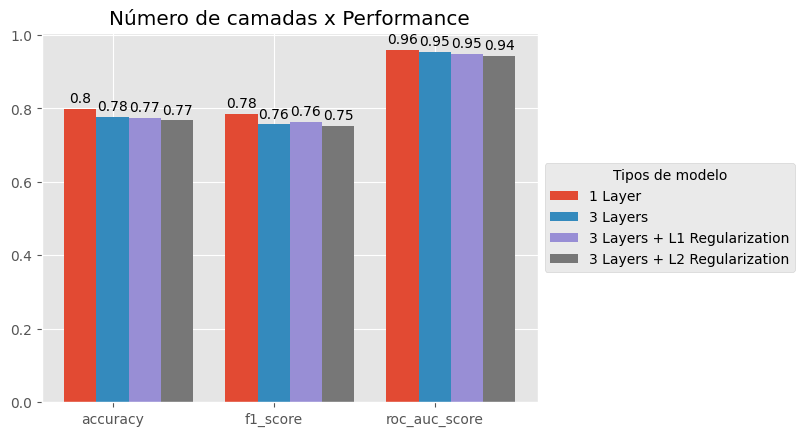

In [65]:
n_layers_models = [model_1layer, model_3layers, model_3layers_reg_l1, model_3layers_reg_l2]
n_layers_labels = ['1 Layer', '3 Layers', '3 Layers + L1 Regularization','3 Layers + L2 Regularization']
plot_bar_stats_chart(n_layers_models, n_layers_labels, x_test, y_test,
                        title='Número de camadas x Performance', save_path='./img/comparacao_n_camadas.png')

In [66]:
generate_model_stats_table(n_layers_models, n_layers_labels, x_test, y_test, precision=3)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


,accuracy,f1_score,roc_auc_score
1 Layer,0.797,0.785,0.958
3 Layers,0.776,0.756,0.954
3 Layers + L1 Regularization,0.772,0.763,0.948
3 Layers + L2 Regularization,0.767,0.753,0.942


Os modelos com 3 camadas ocultas + regularização (L1 e L2) tiveram uma acurácia um pior que o modelo com 3 camadas ocultas sem regularização. Isso demonstra que regulaziação nem sempre é a solução para overfitting e que é necessário testar diferentes arquiteturas para encontrar a melhor solução.

Um ponto importante também é que baseando-se na métrica `roc_auc_score`, o modelo com 1 camada oculta obteve o melhor resultado, o que indica que ele pode ser o mais adequado para esse problema.

| Arquitetura                     | accuracy | f1_score | roc_auc_score |
|---------------------------------|----------|----------|---------------|
| 1 Camada                        | 79.7%    | 78.5%    | 95.8%         |
| 3 Camadas                       | 77.6%    | 75.6%    | 95.4%         |
| 3 Camadas + Regularização L1    | 77.2%    | 76.3%    | 94.8%         |
| 3 Camadas + Regularização L2    | 76.7%    | 75.3%    | 94.2%         |